## KMeans algorithm from scratch

### A Simple Guide to the K-Means Algorithm

#### Author : Joseph Mulindwa

In this notebook, we shall be looking at how the kmeans algorithm works.
KMeans is an **unsupervised learning** algorithm that is used to cluster data in groups - without knowing which group given data elements belong to as are going to see.

In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import matplotlib as mpl

Let's shall generate a random dataset of 1000 points clustered into 3 groups.
<br>We shall add some 10 points for testing later on.

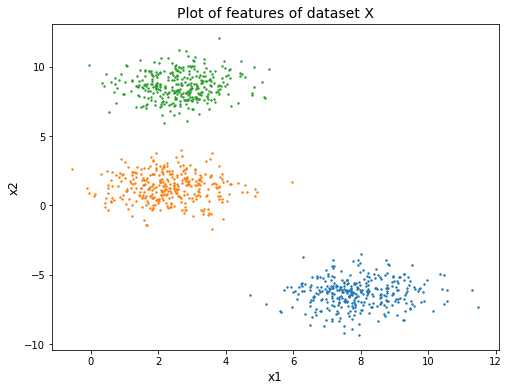

In [2]:
# create a small cluster dataset
N = 1000
X_, y_ = sklearn.datasets.make_blobs(n_samples=N+5, centers=3) # no random_state (set to 42 for good results)
X, y = X_[:N], y_[:N]
X_test, y_test = X_[N:], y_[N:]

plt.figure(figsize=(8, 6))
for cls in np.unique(y):
    plt.scatter(X[y==cls][:, 0], X[y==cls][:, 1], s=2)
plt.title("Plot of features of dataset X", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)
plt.show()

# First things first
1. We need to determine and set a value k, the number of clusters we **think** the data has. KMeans is unsupervised. So it is not the case that you will always know how many clusters (k) exist in the data. You will have to experiment with different values using certain techniques to find the best value of k. For our case, we know that there are 3 clusters, therefore we shall set k to 3. (You can try a different value after the points get clear).
2. We also need to find k=3 random points that will represent the centers of our clusters if the clustering is successfull. These k random points are called centroids.Let's work on these two steps next.

In [3]:
k = 3
N, feature_size = X.shape

# get max and min feature range
min_feature_range = np.min(X, axis=0)
max_feature_range = np.max(X, axis=0)

# generate k random points in the *above range
centroids = np.zeros((len(max_feature_range), k))

for i, (l, h) in enumerate(zip(min_feature_range, max_feature_range)):
    centroids[i] = np.random.uniform(l, h, (3,))

centroids = centroids.T
print(centroids)

[[ 2.10334279 -4.38630113]
 [ 3.31945797 -5.54637235]
 [ 1.77116981 -1.14616642]]


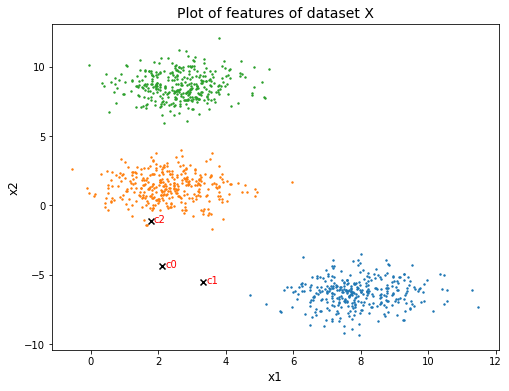

In [4]:
plt.figure(figsize=(8, 6))
for cls in np.unique(y):
    plt.scatter(X[y==cls][:, 0], X[y==cls][:, 1], s=2)
for i, (x_, y_) in enumerate(centroids):
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color='r')
plt.title("Plot of features of dataset X", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)
plt.show()

The points are scattered and may not be close to the cluster centers. Let's leave that for now and hope all will get better with time. I will provide my **personal** method of finding good starting points. There are other methods that you can find online like the **kmeans++**. 

# Lets begin 
## 1. Calculate distances to centroids
In this notebook, we shall be calculating the euclidean distance. We have 2 columns in X *(x1 and x2)* and we have to calculate the euclidean distance between each centroid and every data point in X. Centroids are of the form *(xx, yy)* i.e they have two points just like our dataset X has 2 columns. 
<br>We want to calculate something of the form **sqrt(*(x1-xx)^2 + (x2-yy)^2*)** for each data point/row in X.
<br>We shall be using a vectorized approach to calculate that.
1. We have k=3 centroids, so we shall first duplicate **X** 3 times or k times. The shape of X is (1000, 2). The result of the duplication, **Xc** will be (1000, 6).
2. Then we shall flatten the centroids so that its a single vector, **centroidsc** of 6 elements to match our 6 columns in **Xc**.
3. We shall subtract **Xc** and **centroidsc** to give us a result **D** of shape (1000, 6). This step is equivalent to performing **(x1-xx)** and **(x2-yy)** for all centroids at once. 
* The first column of **D** corresponds to **(x1-xx)** where xx is the x of the first centroid. 
* The second column of **D** corresponds to **(x2-yy)** where yy is the y of the first centroid.
* The third column of **D** corresponds to **(x1-xx)** where xx is the x of the *second* centroid.
* The forth column of **D** corresponds to **(x2-yy)** where yy is the y of the *second* centroid. And so on.
4. The next step is to square these results, add them and apply sqrt. This whole operation results in what is called the *l2 norm* and is all performed by the **np.linalg.norm** function.
<br>Note that we have to calculate the norm over a given set of columns e.g the first and second columns' norm corresponds to the first centroid, the third and forth to the 2nd centroid and the last 2 to the 3rd centroid. So in the end we have a (1000, 3) array containing euclidean distances of each of the 1000 data rows/points in X in correspondence to each of the 3 centroids.
<br>
<br>Let's do that

In [5]:
Xc = np.concatenate([X for c in centroids], axis=1) # duplicate X k times
centroidsc = centroids.ravel() # ravel to allow broadcast
D = (Xc - centroidsc) # raw diff

In [6]:
print(np.round(X[:5], 3))  # X (upto 5) without duplication

[[ 7.15  -8.21 ]
 [ 7.114 -5.837]
 [ 9.52  -4.297]
 [ 0.863  0.606]
 [ 1.83   2.281]]


In [7]:
print(np.round(Xc[:5], 3)) # X (up to 5) with duplication

[[ 7.15  -8.21   7.15  -8.21   7.15  -8.21 ]
 [ 7.114 -5.837  7.114 -5.837  7.114 -5.837]
 [ 9.52  -4.297  9.52  -4.297  9.52  -4.297]
 [ 0.863  0.606  0.863  0.606  0.863  0.606]
 [ 1.83   2.281  1.83   2.281  1.83   2.281]]


In [8]:
print(centroidsc) # raveled centroids

[ 2.10334279 -4.38630113  3.31945797 -5.54637235  1.77116981 -1.14616642]


In [9]:
print(D[:5])  # the difference between Xc and centroids

[[ 5.04688941 -3.82394596  3.83077423 -2.66387474  5.37906239 -7.06408066]
 [ 5.01024479 -1.45058051  3.79412961 -0.29050929  5.34241776 -4.69071521]
 [ 7.41701104  0.08952813  6.20089586  1.24959935  7.74918402 -3.15060658]
 [-1.24030212  4.99219366 -2.4564173   6.15226488 -0.90812914  1.75205896]
 [-0.27356775  6.66720796 -1.48968293  7.82727918  0.05860523  3.42707326]]


* Calculating the norms

In [10]:
Norms = np.zeros((N, k)) # distances to each centroid
for i in range(0, k):
    m = i*feature_size
    Norms[:, i] = np.linalg.norm(D[:, m:m+feature_size], axis=1)

In [11]:
# sample norm / distance
sample_norms = Norms[:4]
sample_norms

array([[6.3319551 , 4.66594683, 8.87893844],
       [5.21600773, 3.80523523, 7.10944701],
       [7.41755135, 6.32555199, 8.36517631],
       [5.14396218, 6.62452633, 1.97342574]])

## 2. Attach instances or rows to the closest centroid.
* We shall now assign each data row in X the index of the centroid with which it has the shortest distance. We do that using **np.argmin** which returns the index of the minimum distance in our *Norms* array. 

In [12]:
# sample of indices for smallest indices for sample_norms
np.argmin(sample_norms, axis=1)

array([1, 1, 1, 2], dtype=int64)

In [13]:
# we do this for all Norms
ypred = np.argmin(Norms, axis=1) 

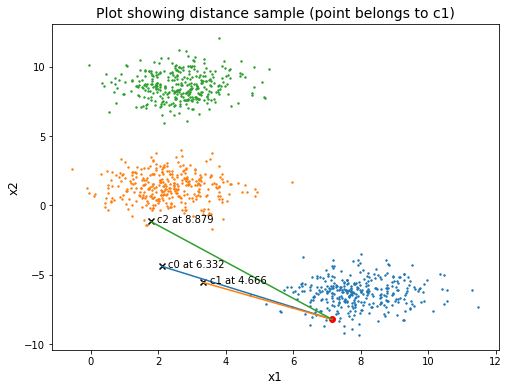

In [14]:
plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids):  # with underscore
    p = plt.scatter(X[y==i][:, 0], X[y==i][:, 1], s=2)
    clr = mpl.colors.to_rgba(p.get_facecolor()) # get color used by matplotlib
    plt.scatter(x_, y_, marker='x', c='k')
    anot = 'c'+str(i) + " at " + str(np.round(Norms[0, i], 3))
    plt.plot([X[0][0], x_], [X[0][1], y_])
    plt.annotate(xy=(x_+.2, y_-.1), text=anot, color='k', size=10)
    
plt.scatter(X[0][0], X[0][1], marker='o', c='r', s=35)

plt.title("Plot showing distance sample (point belongs to c"+str(ypred[0])+")", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)

plt.show()

## 3. Update centroids
The last step is to update the centroids by setting the new centroids at the mean positions of the points they were closest to i.e the data points they influence.
<br>Below is a plot showing the un-updated centroids and their influence on the data points. We shall have to move the centroids so that they are at the center of the points they influence.

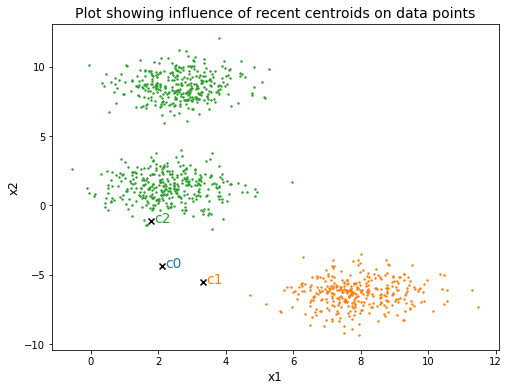

In [15]:
plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids):
    p = plt.scatter(X[ypred==i][:, 0], X[ypred==i][:, 1], s=2)
    clr = mpl.colors.to_rgba(p.get_facecolor()) # get color used by matplotlib
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color=clr, size=14)
plt.title("Plot showing influence of recent centroids on data points", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)
plt.show()

* To do that, we shall calculate the mean of the data points each centroid influences and put the centroid at that mean location. 
* If a centroid has no points it influences (yes, this can happen), we leave the centroid where it is.  

In [16]:
centroids_ = []
for i in range(k):
    if len(X[ypred == i]) == 0:
        centroids_.append(centroids[i]) # use old
    else:
        centroids_.append(np.mean(X[ypred == i], axis=0))
centroids_ = np.array(centroids_)
centroids_

array([[ 2.10334279, -4.38630113],
       [ 7.90037298, -6.3318307 ],
       [ 2.46104719,  4.95620875]])

**After the update, we have the following plot**

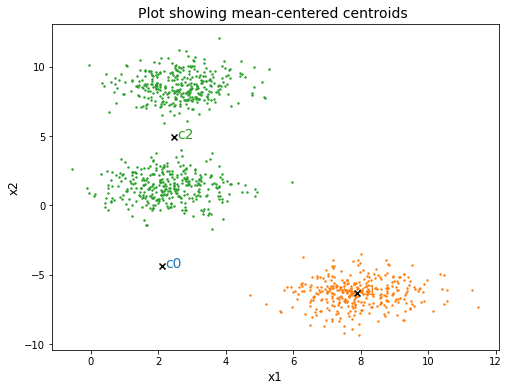

In [17]:
plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids_):  # with underscore
    p = plt.scatter(X[ypred==i][:, 0], X[ypred==i][:, 1], s=2)
    clr = mpl.colors.to_rgba(p.get_facecolor()) # get color used by matplotlib
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color=clr, size=14)
plt.title("Plot showing mean-centered centroids ", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)

plt.show()

#### Note
* The mean-centered points may look good, however the data they influence may still be bad

### Repeat the above steps
* Now we repeat the steps 1 to 3 until the centroids don't update or move (significantly) anymore. That will be the case when **(centroids_ - centroids)^2** is a low value below a certain threshold. A good threshold has to be as low as possible i.e close to or equal to zero.
* Here, we are using **^2** to make larger shifts/updates significant. It doesn't have to be that way. A norm can also work.

In [18]:
shift = np.sum((centroids_ - centroids)**2)
shift

59.31664072563724

* Below we repeat all the previous steps in one run

In [19]:
centroids = centroids_
Xc = np.concatenate([X for c in centroids], axis=1) # duplicate k times
centroidsc = centroids.ravel() # ravel to allow broadcast
D = (Xc - centroidsc) # raw diff

Norms = np.zeros((N, k)) # distances to each cluster
for i in range(0, k):
    m = i*feature_size
    Norms[:, i] = np.linalg.norm(D[:, m:m+feature_size], axis=1)
ypred = np.argmin(Norms, axis=1) # chosen clusters

# new clusters are mean X along 
centroids_ = []
for i in range(k):
    if len(X[ypred == i]) == 0:
        centroids_.append(centroids[i]) # use old
    else:
        centroids_.append(np.mean(X[ypred == i], axis=0))
centroids_ = np.array(centroids_)
centroids_

array([[ 2.17865558, -0.28378518],
       [ 7.90037298, -6.3318307 ],
       [ 2.48351016,  5.37302645]])

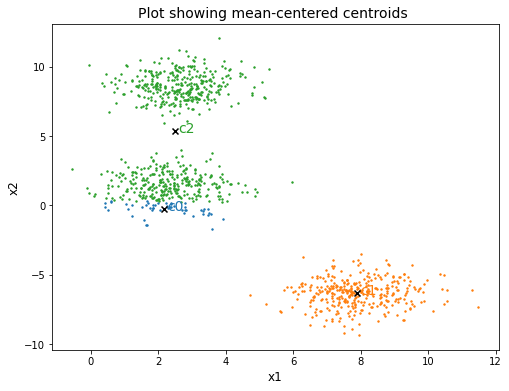

In [20]:
plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids_):  # with underscore
    p = plt.scatter(X[ypred==i][:, 0], X[ypred==i][:, 1], s=2)
    clr = mpl.colors.to_rgba(p.get_facecolor()) # get color used by matplotlib
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color=clr, size=14)
plt.title("Plot showing mean-centered centroids ", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)

plt.show()

[[ 2.29193998  1.10272603]
 [ 7.90037298 -6.3318307 ]
 [ 2.59669958  8.04734936]]


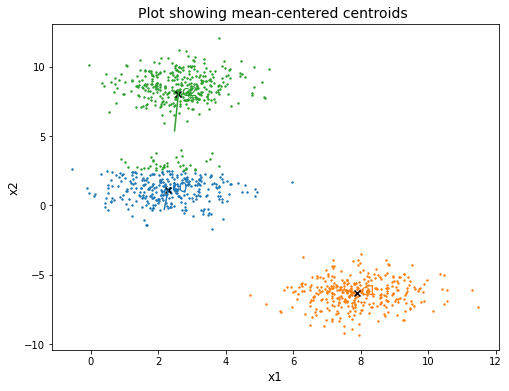

In [21]:
centroids = centroids_
Xc = np.concatenate([X for c in centroids], axis=1) # duplicate k times
centroidsc = centroids.ravel() # ravel to allow broadcast
D = (Xc - centroidsc) # raw diff

Norms = np.zeros((N, k)) # distances to each cluster
for i in range(0, k):
    m = i*feature_size
    Norms[:, i] = np.linalg.norm(D[:, m:m+feature_size], axis=1)
ypred = np.argmin(Norms, axis=1) # chosen clusters

# new clusters are mean X along 
centroids_ = []
for i in range(k):
    if len(X[ypred == i]) == 0:
        centroids_.append(centroids[i]) # use old
    else:
        centroids_.append(np.mean(X[ypred == i], axis=0))
centroids_ = np.array(centroids_)
print(centroids_)

plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids_):  # with underscore
    p = plt.scatter(X[ypred==i][:, 0], X[ypred==i][:, 1], s=2)
    clr = mpl.colors.to_rgba(p.get_facecolor()) # get color used by matplotlib
    plt.scatter(x_, y_, marker='x', c='k')
    plt.plot([x_, centroids[i][0]], [y_, centroids[i][1]], color=clr)
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color=clr, size=14)
plt.title("Plot showing mean-centered centroids ", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)

plt.show()

## Picking random points

Now I will describe my method of initializing points. You can call it the **maximum-distance initializer**. The technique is quite simple. 
<br>
<br>**Repeat**:
<br>*Ensure that each new centroid you add is far away from the currently collected centroids*
<br>**Until** you have k centroids
<br>
<br>**Note**
* The centroids must be chosen from the data points.
* The explanation I will give below does not give the best results however it is fairly optimal and better than pure random selection. Help is needed on this: *Finding the farthest point given a set of points*.
#### Algorithm
1. Pick a random point in the data. This point may be in the middle of the data, however we are after extremes or furthest points. So, use that point to find the farthest point away from it.<br>Discard the first point and keep the point it helped you to find. This point is likely to be at the *edge/extreme* of the dataset.
2. If k > 1, use the current point to find another far point from this one and add it to the centroids so that they are now 2.
3. While the collected centroids are less than k, use the collected centroids to find a point that is far away from **all** of them i.e far from the first and second point.

[[11.48444659 -7.30022546]
 [-0.04870255 10.14697493]
 [ 7.49110847 -9.17813005]]


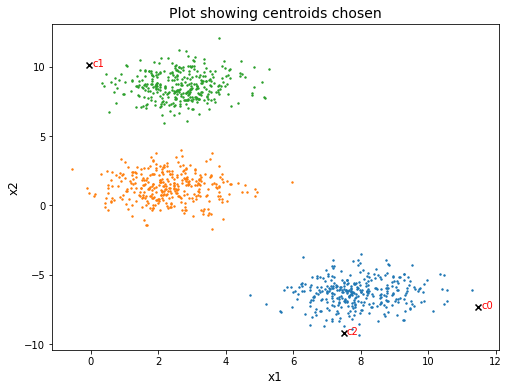

In [22]:
# implementation

# pick a first point; k >= 1
idx = int(np.random.uniform(0, N)) # this point can be anywhere, even in the middle!
# add to centroids
centroids = []
centroid = X[idx]
# so we use that point to find an edge/extreme data point
dists = np.linalg.norm(X - centroid, axis=1)
idx = np.argmax(dists)
centroids = [X[idx]]

# then we keep finding the furthest point from available centroids
norms = np.zeros((N, k))
for i in range(0, k-1):
    norms[:, i] = np.linalg.norm(X - centroids[i], axis=1) # distances to point
    idx = np.argmax(np.sum(norms, axis=1))  # the furthest point from all centroids sofar
    centroids += [X[idx]]

centroids_ = None
centroids = np.array(centroids)
print(centroids)

plt.figure(figsize=(8, 6))
for cls in np.unique(y):
    plt.scatter(X[y==cls][:, 0], X[y==cls][:, 1], s=2)
for i, (x_, y_) in enumerate(centroids):
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color='r')
plt.title("Plot showing centroids chosen", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)
plt.show()

* You may now run the code cell below a number of times manually to see how the centroids change!

[[ 9.12340224 -5.77671375]
 [ 2.43517003  5.22589683]
 [ 6.90978939 -5.82497365]]
shift : 49.86384072016784


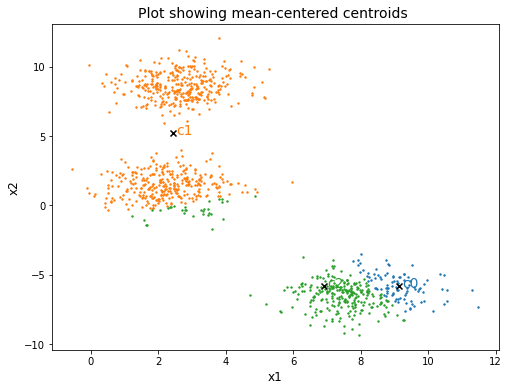

In [23]:
# now re-run kmeans 
if centroids_ is not None:
    centroids = centroids_
Xc = np.concatenate([X for c in centroids], axis=1) # duplicate k times
centroidsc = centroids.ravel() # ravel to allow broadcast
D = (Xc - centroidsc) # raw diff

Norms = np.zeros((N, k)) # distances to each cluster
for i in range(0, k):
    m = i*feature_size
    Norms[:, i] = np.linalg.norm(D[:, m:m+feature_size], axis=1)
ypred = np.argmin(Norms, axis=1) # chosen clusters

# new clusters are mean X along 
centroids_ = []
for i in range(k):
    if len(X[ypred == i]) == 0:
        centroids_.append(centroids[i]) # use old
    else:
        centroids_.append(np.mean(X[ypred == i], axis=0))
centroids_ = np.array(centroids_)
print(centroids_)

shift = np.sum((centroids_ - centroids)**2)
print("shift :", shift)

plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids_):  # with underscore
    p = plt.scatter(X[ypred==i][:, 0], X[ypred==i][:, 1], s=2)
    clr = mpl.colors.to_rgba(p.get_facecolor()) # get color used by matplotlib
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color=clr, size=14)
plt.title("Plot showing mean-centered centroids ", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)

plt.show()

Alternatively, you can use a while look to keep the program running until it converges.
* How does a kmeans algorithm converge - in other words when should it stop running?
The answer to this question is already included in this notebook!

In [24]:
# the whole Algorithm

# pick a first point; k >= 1
idx = int(np.random.uniform(0, N)) # this point can be anywhere, even in the middle!
# add to centroids
centroids = []
centroid = X[idx]
# so we use that point to find an edge/extreme data point
dists = np.linalg.norm(X - centroid, axis=1)
idx = np.argmax(dists)
centroids = [X[idx]]

# then we keep finding the furthest point from available centroids
norms = np.zeros((N, k))
for i in range(0, k-1):
    norms[:, i] = np.linalg.norm(X - centroids[i], axis=1) # distances to point
    idx = np.argmax(np.sum(norms, axis=1))  # the furthest point from all centroids sofar
    centroids += [X[idx]]

centroids_ = None
centroids = np.array(centroids)

shift = 1

while shift > 0.0: # our threshold is 0.0
    if centroids_ is not None:
        centroids = centroids_
    Xc = np.concatenate([X for c in centroids], axis=1) # duplicate k times
    centroidsc = centroids.ravel() # ravel to allow broadcast
    D = (Xc - centroidsc) # raw diff

    Norms = np.zeros((N, k)) # distances to each cluster
    for i in range(0, k):
        m = i*feature_size
        Norms[:, i] = np.linalg.norm(D[:, m:m+feature_size], axis=1)
    ypred = np.argmin(Norms, axis=1) # chosen clusters

    # new clusters are mean X along 
    centroids_ = []
    for i in range(k):
        if len(X[ypred == i]) == 0:
            centroids_.append(centroids[i]) # use old
        else:
            centroids_.append(np.mean(X[ypred == i], axis=0))
    centroids_ = np.array(centroids_)

    shift = np.sum((centroids_ - centroids)**2)
    print("shift :", shift)

shift : 58.281324464398686
shift : 9.306185516624048
shift : 0.037577665608409916
shift : 0.0


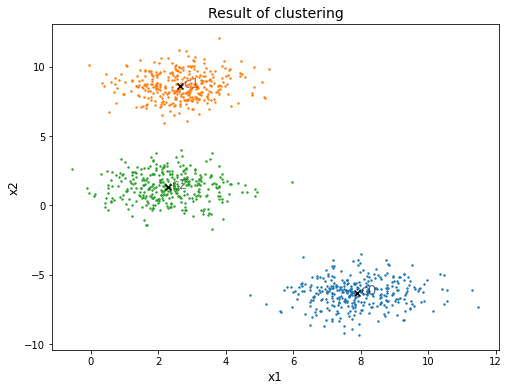

In [25]:
plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids_):  # with underscore
    p = plt.scatter(X[ypred==i][:, 0], X[ypred==i][:, 1], s=2)
    fclr = [v-.3 if v-.3 > 0 else v for v in p.get_facecolor()[0]] # get color used by matplotlib
    clr = mpl.colors.to_rgba(np.array(fclr)) 
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.1, y_-.1), text='c'+str(i), color=clr, size=14)
plt.title("Result of clustering", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)

plt.show()

### Prediction
1. Calculate distance between the new data point(s) and the centroids
2. Pick the centroid a point is closest to. The new data point will belong to the cluster where that centroid is.

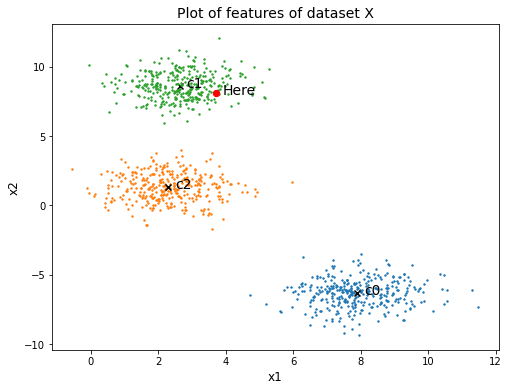

In [26]:
tindx = 0
test = X_test[tindx]

# Plot test data
plt.figure(figsize=(8, 6))
for i, (x_, y_) in enumerate(centroids_):  # with underscore
    p = plt.scatter(X[y==i][:, 0], X[y==i][:, 1], s=2)
    plt.scatter(x_, y_, marker='x', c='k')
    plt.annotate(xy=(x_+.2, y_-.1), text='c'+str(i), color='k', size=14)

x_, y_ = test
plt.scatter(x_, y_, c='r', s=40)
plt.annotate(xy=(x_+.2, y_-.1), text='Here', color='k', size=14)
plt.title("Plot of features of dataset X", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)
plt.show()

In [27]:
# let's try to predict its cluster

dists = np.zeros((k,))
for i, (x_, y_) in enumerate(centroids):
    dists[i] = np.linalg.norm([test[0] - x_, test[1]-y_])
print(dists)

[15.05704676  1.18520049  6.95705346]


In [28]:
cl = np.argmin(dists)
print("The new point belongs to c"+str(cl))

The new point belongs to c1


Try it out with differnt values of **tindx**. Remember tindx can't exceed 9 since we got only 10 more points to test on.